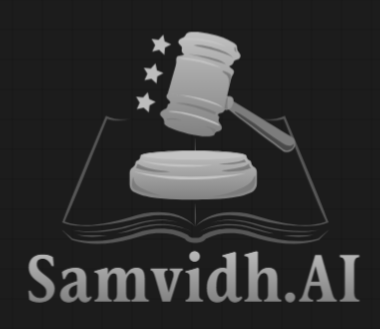
# **⚖️ Samvidh.AI**
### Making Legal Documents Simple, Safe & Smart

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ======================
# 1. Install Dependencies
# ======================
!pip install pdfminer.six python-docx nltk requests fpdf sentence-transformers faiss-cpu langchain-community

In [ ]:
# ======================
# 2. Imports & Setup
# ======================
import os, re, tempfile, requests, time
import docx
import nltk
from pdfminer.high_level import extract_text as pdf_extract
from nltk.tokenize import sent_tokenize
from fpdf import FPDF
import ipywidgets as widgets
from IPython.display import display, Markdown
from google.colab import files
# For embeddings + RAG
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

# Download NLTK resources
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# ======================
# 3. Branding Header
# ======================
from IPython.display import display
import ipywidgets as widgets

logo_path = "/content/drive/MyDrive/SamvidhAI.logo.png"

branding_html = widgets.HTML(
    value="""
    <div style='margin-left:15px;'>
        <h1 style='color:#FFFFFF; font-family:Arial;'>
            ⚖️ <b>Samvidh.AI</b>
        </h1>
        <h4 style='color:#DDDDDD; font-family:Arial;'>
            Making Legal Documents Simple, Safe & Smart
        </h4>
    </div>
    """
)

# Load logo widget
with open(logo_path, "rb") as f:
    logo_data = f.read()
logo_widget = widgets.Image(value=logo_data, format='png', width=100, height=100)

# Display logo + title
display(widgets.HBox([logo_widget, branding_html]))

In [ ]:
# ======================
# 4. Groq API Config
# ======================
GROQ_API_KEY = "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"
GROQ_URL = "https://api.groq.com/openai/v1/chat/completions"
MODEL_NAME = "meta-llama/llama-4-scout-17b-16e-instruct"

In [ ]:
# ======================
# 5. Utilities
# ======================
def extract_text(file_path: str) -> str:
    ext = os.path.splitext(file_path)[1].lower()
    if ext == ".pdf":
        text = pdf_extract(file_path)
    elif ext == ".docx":
        doc = docx.Document(file_path)
        text = "\n".join(p.text for p in doc.paragraphs)
    elif ext == ".txt":
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            text = f.read()
    else:
        raise ValueError("Unsupported file")
    return re.sub(r"\n\s*\n", "\n", text).strip()

def split_into_paragraphs(text: str):
    return [p.strip() for p in text.split("\n") if p.strip()]

def smart_chunk(paragraphs, max_sentences=6):
    chunks, current = [], []
    for para in paragraphs:
        for sent in sent_tokenize(para):
            current.append(sent)
            if len(current) >= max_sentences:
                chunks.append(" ".join(current))
                current = []
    if current:
        chunks.append(" ".join(current))
    return chunks

In [ ]:
# ======================
# 6. Groq LLM Wrapper
# ======================
def groq_call(prompt: str) -> str:
    headers = {"Authorization": f"Bearer {GROQ_API_KEY}", "Content-Type": "application/json"}
    data = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "system", "content": "You are a legal assistant."},
            {"role": "user", "content": prompt}
        ],
        "max_tokens": 1500,
        "temperature": 0.2
    }
    r = requests.post(GROQ_URL, headers=headers, json=data)
    j = r.json()
    return j.get("choices", [{}])[0].get("message", {}).get("content", str(j))


In [ ]:
# ======================
# 7. Single-pass Doc Analysis
# ======================
def process_legal_doc(file_path: str):
    text = extract_text(file_path)
    prompt = f"""
    Analyze the following contract:

    ---- START ----
    {text[:10000]}
    ---- END ----

    Please output in this format:

    EXECUTIVE SUMMARY:
    ...

    RISK ANALYSIS:
    ...

    DEMYSTIFIED EXPLANATION:
    ...

    KEY CLAUSES:
    ...
    """
    output = groq_call(prompt)
    return parse_sections(output)

def parse_sections(output: str):
    sections = {"summary":"", "risks":"", "demystified":"", "clauses":""}
    s = re.search(r"EXECUTIVE SUMMARY:(.*?)(RISK ANALYSIS:|$)", output, re.S)
    r = re.search(r"RISK ANALYSIS:(.*?)(DEMYSTIFIED|KEY CLAUSES|$)", output, re.S)
    d = re.search(r"DEMYSTIFIED EXPLANATION:(.*?)(KEY CLAUSES|$)", output, re.S)
    c = re.search(r"KEY CLAUSES:(.*)", output, re.S)
    if s: sections["summary"] = s.group(1).strip()
    if r: sections["risks"] = r.group(1).strip()
    if d: sections["demystified"] = d.group(1).strip()
    if c: sections["clauses"] = c.group(1).strip()
    return sections

# Risk color highlighting
def format_risks(txt: str):
    return (txt.replace("High", "🔴 High")
               .replace("Medium", "🟠 Medium")
               .replace("Low", "🟢 Low"))

In [ ]:
# ======================
# 8. Q&A Bot (RAG)
# ======================
def build_index(chunks):
    emb = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    return FAISS.from_texts(chunks, emb)

def legal_qa_bot(question, db):
    ctx = "\n\n".join([r.page_content for r in db.similarity_search(question, k=3)])
    prompt = f"Use context to answer:\n\n{ctx}\n\nQ: {question}\nA:"
    return groq_call(prompt)


In [ ]:
# ======================
# 9. PDF Export
# ======================
def export_pdf(sections, filename="SamvidhAI_Report.pdf"):
    pdf = FPDF()
    pdf.add_page()
    try: pdf.image(logo_path, 10, 8, 33)
    except: pass
    pdf.set_font("Arial", "B", 16)
    pdf.cell(200, 15, "Samvidh.AI - Legal Contract Analyzer", ln=True, align="C")
    pdf.set_font("Arial", "I", 12)
    pdf.cell(200, 10, "Making Legal Documents Simple, Safe & Smart", ln=True, align="C")
    pdf.ln(15)
    for title, key in [("EXECUTIVE SUMMARY","summary"),
                       ("RISK ANALYSIS","risks"),
                       ("KEY CLAUSES","clauses"),
                       ("DEMYSTIFIED","demystified")]:
        pdf.set_font("Arial", "B", 13); pdf.cell(200, 10, title, ln=True)
        pdf.set_font("Arial", "", 11); content = sections.get(key,"")
        if key=="risks": content = format_risks(content)
        pdf.multi_cell(0, 8, content); pdf.ln(5)
    pdf.output(filename)
    files.download(filename)

# **Prototype Preview**

In [ ]:
# @title
# ======================
# 10. UI Widgets
# ======================
display(widgets.HBox([logo_widget, branding_html]))
root_folder = "/content/drive/MyDrive/hackathon Gen AI/archive (2)/CUAD_v1/full_contract_pdf"
part_dd, domain_dd, file_dd = widgets.Dropdown(description="Part:"), widgets.Dropdown(description="Domain:"), widgets.Dropdown(description="Contract:")

btn_load = widgets.Button(description="📂 Analyze", button_style="primary")
btn_upload = widgets.Button(description="⬆️ Upload Contract", button_style="info")
btn_download = widgets.Button(description="⬇️ Download PDF", button_style="warning")

summary_out, risks_out, clauses_out, demyst_out, qa_out = [widgets.Output() for _ in range(5)]
tabs = widgets.Tab(children=[summary_out, risks_out, clauses_out, demyst_out, qa_out])
for i,t in enumerate(["📑 Summary","⚠️ Risks","📜 Clauses","📝 Demystified","💬 Q&A"]):
    tabs.set_title(i,t)
qa_box, qa_btn, qa_area = widgets.Text(placeholder="Ask..."), widgets.Button(description="Ask",button_style="success"), widgets.Output()

sections_cache, text_cache, db_cache = {}, "", None

def update_parts(): part_dd.options=[f for f in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder,f))]
def update_domains(*_): domain_dd.options=[f for f in os.listdir(os.path.join(root_folder,part_dd.value))] if part_dd.value else []
def update_files(*_):
    if domain_dd.value:
        p=os.path.join(root_folder,part_dd.value,domain_dd.value)
        file_dd.options=[f for f in os.listdir(p) if f.lower().endswith((".pdf",".docx",".txt"))]

part_dd.observe(update_domains,'value'); domain_dd.observe(update_files,'value')

def analyze(file):
    global sections_cache,text_cache,db_cache
    text_cache = extract_text(file)
    sections_cache = process_legal_doc(file)
    for o in [summary_out,risks_out,clauses_out,demyst_out,qa_out,qa_area]: o.clear_output()
    with summary_out: display(Markdown("### Executive Summary")); display(Markdown(sections_cache["summary"]))
    with risks_out: display(Markdown("### Risk Analysis")); display(Markdown(format_risks(sections_cache["risks"])))
    with clauses_out: display(Markdown("### Key Clauses")); display(Markdown(sections_cache["clauses"]))
    with demyst_out: display(Markdown("### Demystified")); display(Markdown(sections_cache["demystified"]))
    with qa_out: display(qa_box, qa_btn, qa_area)
    paras=split_into_paragraphs(text_cache); chunks=smart_chunk(paras); db_cache=build_index(chunks)

btn_load.on_click(lambda b: analyze(os.path.join(root_folder,part_dd.value,domain_dd.value,file_dd.value)))
btn_upload.on_click(lambda b:[(f:=files.upload()) and analyze(list(f.keys())[0])])
qa_btn.on_click(lambda b:[qa_area.clear_output(), qa_area.append_display_data(Markdown(f"**Q:** {qa_box.value}\n\n**A:** {legal_qa_bot(qa_box.value,db_cache)}"))])
btn_download.on_click(lambda b: export_pdf(sections_cache))

update_parts()
display(widgets.VBox([
    widgets.HBox([part_dd,domain_dd]),
    widgets.HBox([file_dd]),
    widgets.HBox([btn_load,btn_upload,btn_download]),
    tabs
]))
